<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)
device_name = torch.cuda.get_device_name(dnumber)
print(device_name)

True
1
cuda:0
NVIDIA A100-SXM4-80GB


In [ ]:
def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)


def generatePrior(sampleSize):
    N1 = np.random.uniform(10,50,sampleSize)
    N2 = np.random.uniform(10,30,sampleSize)

    mu1 = np.random.uniform(1,3,sampleSize)
    mu2 = np.random.uniform(5,9,sampleSize)

    sig1 = np.random.uniform(1,3,sampleSize)
    sig2 = np.random.uniform(5,9,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2


sampleNumber = 10000000

N1,mu1,sig1,N2,mu2,sig2 = generatePrior(sampleNumber)

raw = np.arange(0.5,10,1) #startbinCenter, endBinEdge, StepSize [0.5,1.5...9.5]
gaussTotal = gauss(N1,mu1,sig1,raw) + gauss(N2,mu2,sig2,raw)

binNumber = len(gaussTotal)
dataPoisson = np.random.poisson(lam=gaussTotal,size=None)

thetaData = np.column_stack((N1,mu1,sig1,N2,mu2,sig2))

I am going to normalize the data using min-max I can preserve the relationships while keeping it ideal for sigmoid to take part perhaps. I also found appraches involving log, if this does not work I will look into that.

In [ ]:
max_vals = torch.tensor(np.max(dataPoisson, axis = 0))
min_vals = torch.tensor(np.min(dataPoisson, axis = 0))
input_p = torch.tensor(dataPoisson,dtype=torch.float32)

We may have to rethink structure of data storage for CNF later. But for now the autoencoder simply needs to take the 10-D output in and minimize loss.

In [ ]:
Datasets = DataLoader(input_p, batch_size =4096, shuffle=True)

#for data in Datasets:
#  print(data.shape)

In [ ]:
class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()

    self.max = torch.nn.Parameter(max_vals,requires_grad=False)
    self.min = torch.nn.Parameter(min_vals,requires_grad=False)

    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,hidden_dim),
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(hidden_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,input_dim)
    )

  def forward(self,x):
    x = (x-self.min)/(self.max - self.min)
    encode = self.encoder(x)
    decode = self.decoder(encode)
    return decode

In [ ]:
lr = 1e-4
inputDim = 10
hiddenDim = 6
compress = autoEncoder(inputDim, hiddenDim).to(device)
optim = torch.optim.Adam(compress.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
torchinfo.summary(compress)

Layer (type:depth-idx)                   Param #
autoEncoder                              20
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
Total params: 1,124
Trainable params: 1,104
Non-trainable params: 20

100%|██████████| 5/5 [03:06<00:00, 37.22s/it]

5


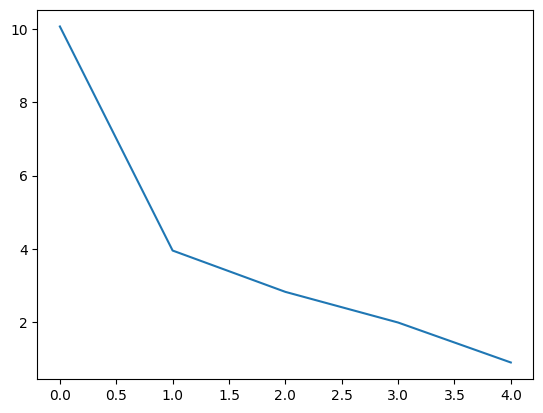

In [ ]:
max_iter = 5
losses = []


for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True)
      optim.zero_grad()
      y_pred = compress(x_batch)
      loss = loss_fn(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      optim.step()

  losses.append(np.mean(np.array(iter_losses)))

print(len(losses))
plt.plot(losses)


In [ ]:
print(losses[-1])

0.8931076244483904
